In [1]:
# Selina 26 Feb 2019
# Program to create a logistic regression model to predict readmission rates
# Import relevant modules
import os
import numpy as np
import pandas as pd
#from sklearn import datasets, linear_model
#from sklearn.metrics import mean_squared_error, r2_score

# Set directories, filenames and url api
dataFolder = os.getcwd()
inputFileName='10kDiabetes.csv'
    # This is my filename with merged data and geodata
input_file=os.path.join(dataFolder,inputFileName)

# Read in data
raw_data=pd.read_csv(input_file)
#raw_data.columns  Have a look at what the columns are and see the unique info
#raw_data.loc[:,'readmitted'].unique()


In [2]:
# Ok, first apply criteria for acceptance of data
# Apply the same criteria as the paper used

# First of all, we only want to look at inpatient encounters 
# with hospitaliztion that lasted 1-14 days
cleaned_data=raw_data.copy()

idx1=cleaned_data.index[cleaned_data['time_in_hospital']>0]
idx2=cleaned_data.index[cleaned_data['time_in_hospital']<=14]
idx=idx1 & idx2
cleaned_data=cleaned_data.loc[idx,:]

# Ok, for our analysis, remove patient data with multiple inpatient encounters
idx=cleaned_data.index[cleaned_data['number_inpatient']==0]
cleaned_data=cleaned_data.loc[idx,:]
#cleaned_data.columns

# Only look at data where patients have been diagnosed with diabetes
idx1=cleaned_data['diag_1_desc'].str.contains('diabetes mellitus',case=False)
idx2=cleaned_data['diag_2_desc'].str.contains('diabetes mellitus',case=False)
idx3=cleaned_data['diag_3_desc'].str.contains('diabetes mellitus',case=False)
idx=idx1 | idx2 | idx3
idx=idx[idx==True]

cleaned_data=cleaned_data.loc[idx.index,:]
#Series.str.contains(pat, case=True, flags=0, na=nan, regex=True)[source]

# Remove data where patient died or was transfered to hospice
idx1=cleaned_data['discharge_disposition_id'].str.contains('expired',case=False)
idx2=cleaned_data['discharge_disposition_id'].str.contains('hospice',case=False)
idx3=cleaned_data['discharge_disposition_id'].apply(pd.isnull)
idx=(idx1 | idx2)
idx=idx[idx==True]
cleaned_data=cleaned_data.drop(index=idx.index)
idx3=idx3[idx3==True]
cleaned_data.loc[idx3.index,'discharge_disposition_id']='NA'

# Also, clean up data
idx=cleaned_data.index[cleaned_data['race']=='?']
cleaned_data.loc[idx,'race']='NA'

idx1=cleaned_data.index[cleaned_data['admission_type_id'].apply(pd.isnull)]
idx2=cleaned_data.index[cleaned_data['admission_type_id']=='Not Available']
idx3=cleaned_data.index[cleaned_data['admission_type_id']=='Not Mapped']
idx=idx1 | idx2 | idx3
cleaned_data.loc[idx,'admission_type_id']='NA'

# Note: Medical specialty had many missing values in paper
idx=cleaned_data.index[cleaned_data['medical_specialty']=='?']
cleaned_data.loc[idx,'medical_specialty']='NA'

# We can drop payer code because it will not be relevant
cleaned_data=cleaned_data.drop(columns='payer_code')




In [3]:
# Do some regrouping...
# Regroup data into home and other (create new variable)
idx=cleaned_data['discharge_disposition_id'].str.contains('home',case=False)
idx1=idx[idx==True]
cleaned_data.loc[idx1.index,'discharge_home']=idx1
idx2=idx[idx!=True]
cleaned_data.loc[idx2.index,'discharge_home']=idx2
idx3=cleaned_data['discharge_disposition_id']=='NA'
idx3=idx3[idx3==True]
cleaned_data.loc[idx3.index,'discharge_home']='NA'

# Regroup ages like paper, <30, 30-60, 60-100
idx1=cleaned_data[cleaned_data.age=='[0-10)']
idx2=cleaned_data[cleaned_data.age=='[10-20)']
idx3=cleaned_data[cleaned_data.age=='[20-30)']
idx=idx1 | idx2 | idx3
idx=idx[idx==True]
cleaned_data.loc[idx.index,'grouped_age']='<30'
idx1=cleaned_data[cleaned_data.age=='[30-40)']
idx2=cleaned_data[cleaned_data.age=='[40-50)']
idx3=cleaned_data[cleaned_data.age=='[50-60)']
idx=idx1 | idx2 | idx3
idx=idx[idx==True]
cleaned_data.loc[idx.index,'grouped_age']='[30-60)'
idx1=cleaned_data[cleaned_data.age=='[60-70)']
idx2=cleaned_data[cleaned_data.age=='[70-80)']
idx3=cleaned_data[cleaned_data.age=='[80-90)']
idx4=cleaned_data[cleaned_data.age=='[90-100)']
idx=idx1 | idx2 | idx3 | idx4
idx=idx[idx==True]
cleaned_data.loc[idx.index,'grouped_age']='[60-100)'

# # Let's treat age as a quantity
# unique_age=np.sort(cleaned_data['age'].unique())

# start_age=5
# for ii,var in enumerate(unique_age):
#     idx=cleaned_data[cleaned_data.age==var]
#     idx=idx[idx==True]
#     cleaned_data.loc[idx.index,'quant_age']=start_age
#     start_age+=10

# idx=cleaned_data[cleaned_data.age=='[10-20)']
# idx=idx[idx==True]
# cleaned_data.loc[idx.index,'quant_age']=15

# idx=cleaned_data[cleaned_data.age=='[20-30)']
# idx=idx[idx==True]
# cleaned_data.loc[idx.index,'grouped_age']=25

# idx=cleaned_data[cleaned_data.age=='[30-40)']
# idx=idx[idx==True]
# cleaned_data.loc[idx.index,'quant_age']=35


# idx2=cleaned_data[cleaned_data.age=='[40-50)']
# idx3=cleaned_data[cleaned_data.age=='[50-60)']
# idx=idx1 | idx2 | idx3
# idx=idx[idx==True]
# cleaned_data.loc[idx.index,'grouped_age']='[30-60)'
# idx1=cleaned_data[cleaned_data.age=='[60-70)']
# idx2=cleaned_data[cleaned_data.age=='[70-80)']
# idx3=cleaned_data[cleaned_data.age=='[80-90)']
# idx4=cleaned_data[cleaned_data.age=='[90-100)']
# idx=idx1 | idx2 | idx3 | idx4
# idx=idx[idx==True]
# cleaned_data.loc[idx.index,'grouped_age']='[60-100)'



# Regroup medical specialty into Cardiology, General Practise, Internal medicine, NA, other, Surgery
# For this case, easier to create dummy variables directly, because sometimes 
# there are mixed specialties
idx1=cleaned_data['medical_specialty'].str.contains('cardiology',case=False)
#idx1=idx1[idx1==True]
cleaned_data.loc[idx1.index,'medspec_cardio']=idx1
idx2=cleaned_data['medical_specialty'].str.contains('GeneralPractice',case=False)
#idx=idx[idx==True]
cleaned_data.loc[idx2.index,'medspec_gp']=idx2
idx3=cleaned_data['medical_specialty'].str.contains('InternalMedicine',case=False)
#idx=idx[idx==True]
cleaned_data.loc[idx3.index,'medspec_intmed']=idx3
idx4=cleaned_data['medical_specialty'].str.contains('Surgery',case=False)
#idx=idx[idx==True]
cleaned_data.loc[idx4.index,'medspec_surgery']=idx4
idx5=cleaned_data['medical_specialty']=='NA'
#idx=idx[idx==True]
cleaned_data.loc[idx5.index,'medspec_NA']=idx5
idx_o=idx1 | idx2 | idx3 | idx4 | idx5 # All other specialties
idx_o=idx_o[idx_o==False]
cleaned_data.loc[idx_o.index,'medspec_other']=idx_o

# Regroup admission into emergency, referral and other
idx1=cleaned_data['admission_source_id'].str.contains('emergency',case=False)
#idx1=idx1[idx1==True]
cleaned_data.loc[idx1.index,'grouped_admission']='emergency'
idx2=cleaned_data['admission_source_id'].str.contains('referral',case=False)
#idx1=idx1[idx1==True]
cleaned_data.loc[idx2.index,'grouped_admission']='referral'
idx_na1=cleaned_data['admission_source_id'].apply(pd.isnull)
idx_na2=cleaned_data['admission_source_id'].str.contains('Not Available',case=False)
idx_na=idx_na1 | idx_na2
cleaned_data.loc[idx_na.index,'grouped_admission']='NA'
idx_o=idx1 | idx2 | idx_na
idx_o=idx_o[idx_o==False]
cleaned_data.loc[idx2.index,'grouped_admission']='other'

# And finally..diagnosis
idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=390) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=459)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==785
idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='circulatory'

idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=520) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=579)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==787
idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='digestive'

idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=580) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=629)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==788
idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='genitourinary'

idx=cleaned_data['diag_1'].str.contains('250\.',case=False)
idx=idx[idx==True]
#idx=cleaned_data.diag_1=='250...'
cleaned_data.loc[idx.index,'primary_diagnosis']='diabetes'

idx=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=800) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=999)
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='injury'

idx=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=710) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=739)
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='muskuloskeletal'
idx=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=140) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=239)
idx=idx[idx==True]

cleaned_data.loc[idx.index,'primary_diagnosis']='neoplasm'
idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=460) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=519)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==786

idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='respiratory'
idx_o=cleaned_data['primary_diagnosis'].apply(pd.isnull)
idx_o=idx_o[idx_o==True]
cleaned_data.loc[idx_o.index,'primary_diagnosis']='other'
# And put NA if originally there was no data
idx_na=cleaned_data['diag_1'].apply(pd.isnull)
idx_na=idx_na[idx_na==True]
cleaned_data.loc[idx_na.index,'primary_diagnosis']='NA'




In [5]:
# Ok..now let's do the logistic regression
# We will take a different approach from the paper, since the A1C measurement 
# is not the focus
# Our goal is to identify the risk of readmission, whatever the predictors could be
# So, first let's fit a saturated model

# # First let's get our predictors in the right format
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import sklearn.metrics



y=cleaned_data.loc[:,'readmitted'] 

# First deal with categorical variables
cat_variables=['race','gender','admission_type_id','grouped_age', \
                'grouped_admission','max_glu_serum','A1Cresult','change',\
               'diabetesMed','discharge_home','primary_diagnosis']
#,'grouped_age' left out
# cat_variables=['grouped_age','admission_type_id','change','discharge_home','primary_diagnosis','A1Cresult']
#cat_variables=['change']
X=pd.DataFrame()
X = X.fillna(0) # with 0s rather than NaNs
for ii,var in enumerate(cat_variables):
    xdummy=pd.get_dummies(cleaned_data.loc[:,var],prefix=var,drop_first=True)
    X=pd.concat([X,xdummy],axis=1)

# Now deal with quantitative varibles
quant_variables=['num_lab_procedures','num_procedures','num_medications','number_outpatient',\
                'number_emergency','time_in_hospital']
# quant_variables=['num_lab_procedures','num_procedures',\
#                  'number_emergency','time_in_hospital']

# Now add to our X
for ii,var in enumerate(quant_variables):
    xtemp=cleaned_data.loc[:,var]
    X=pd.concat([X,xtemp],axis=1)

    
# Now split our data into 2 groups:
# 1. Training set & testing set
# Split into 80:20
X_train, X_xtest, y_train, y_xtest = train_test_split(X, y, test_size=0.2)



In [6]:
# ## Ok..we saw from our data exploration that our sample is bias to not_readmitted
# # Will this  affect the logistic regression model?
# # Subsampling reduces prediction power..better not to subsample..
# # So, subsample the not_readmitted training data so that readmitted and not_readmitted
# # are equally sampled
# drop_n=sum(y_train==False)-sum(y_train==True) # Total # of samples you wanna drop
# maxn=sum(y_train==True) # Total number of subsamples that you want
# weights1=(y_train==False) # Only sample from not_readmitted data
# weights2=(y_train==True) # Sample all of the readmitted data
# xsub_train1=X_train.sample(n=maxn,weights=weights1,random_state=2) # Randomly subsampled data
# xsub_train2=X_train.sample(n=maxn,weights=weights2)
# Xsub_train=pd.concat([xsub_train1,xsub_train2],axis=0)
# # Ok, we have subsampled, now shuffle back the data
# Xsub_train=Xsub_train.sample(frac=1)
# ysub_train=y_train.reindex(index=Xsub_train.index) #Subsample y

# # Ok, put the training data we did not use into the testing data
# y_train=y_train.drop(index=Xsub_train.index)
# X_train=X_train.drop(index=Xsub_train.index)
# y_xtest=pd.concat([y_xtest,y_train],axis=0)
# X_xtest=pd.concat([X_xtest,X_train],axis=0)

# # And set your training data to subsampled
# X_train=Xsub_train
# y_train=ysub_train
        

In [38]:
# Ok, let's fit the saturated model
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler

#scaler=StandardScaler() # Scale data
#Xsub_train1=scaler.fit_transform(Xsub_train)
# Xsub_train=add_constant(Xsub_train)
# logreg=Logit(ysub_train,Xsub_train)
X_train=add_constant(X_train)
logreg=Logit(y_train,X_train)

#Logit.fit_regularized(start_params=None, method='l1', maxiter='defined_by_method', full_output=1, disp=1, callback=None, alpha=0, trim_mode='auto', auto_trim_tol=0.01, size_trim_tol=0.0001, qc_tol=0.03, **kwargs)
#satmodel=logreg.fit_regularized(method='l1',maxiter=100,verbose=True)
satmodel=logreg.fit(maxiter=100,verbose=True,method='bfgs')
# Check if logitmodel converged, if not start where we left
while satmodel.mle_retvals['converged']==False:
    satmodel=logreg.fit(maxiter=100,start_params=satmodel.params,verbose=True,method='bfgs')
    


Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.5882219319367251
            Iterations: 101
            Function evaluations: 106
            Gradient evaluations: 101
         Current function value: 0.588162
         Iterations: 100
         Function evaluations: 105
         Gradient evaluations: 105


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.588162
         Iterations: 38
         Function evaluations: 42
         Gradient evaluations: 42


In [39]:
# Let's take a look at the model
satmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                 1828
Model:                          Logit   Df Residuals:                     1792
Method:                           MLE   Df Model:                           35
Date:                Wed, 27 Feb 2019   Pseudo R-squ.:                 0.03242
Time:                        04:46:41   Log-Likelihood:                -1075.2
converged:                       True   LL-Null:                       -1111.2
                                        LLR p-value:                 0.0002271
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -2.3573      0.716     -3.291      0.001      -3.761      -0.954
race_Asian                            0.1582      0.608      0.260      0.795      -1.033       1.349
race_Caucasian                        0.1763      0.133      1.329      0.184      -0.084       0.436
race_Hispanic                        -0.1039      0.368     -0.282      0.778      -0.826       0.618
race_NA                              -0.4290      0.362     -1.185      0.236      -1.139       0.280
race_Other                           -0.4792      0.573     -0.836      0.403      -1.602       0.644
gender_Male                          -0.0848      0.108     -0.786      0.432      -0.296       0.127
admission_type_id_Emergency           0.1501      0.162      0.929      0.353      -0.167       0.467
admission_type_id_NA                  0.2469      0.211      1.172      0.241      -0.166       0.660
admission_type_id_Urgent             -0.0800      0.185     -0.433      0.665      -0.442       0.282
grouped_age_[30-60)                  -0.0017      0.295     -0.006      0.995      -0.580       0.576
grouped_age_[60-100)                  0.5447      0.299      1.823      0.068      -0.041       1.130
max_glu_serum_>300                    0.4588      0.674      0.681      0.496      -0.861       1.779
max_glu_serum_None                    0.6460      0.492      1.314      0.189      -0.318       1.610
max_glu_serum_Norm                    0.1536      0.556      0.276      0.782      -0.936       1.244
A1Cresult_>8                          0.5413      0.336      1.611      0.107      -0.117       1.200
A1Cresult_None                        0.4298      0.303      1.421      0.155      -0.163       1.023
A1Cresult_Norm                        0.0123      0.403      0.030      0.976      -0.778       0.803
change_No                            -0.2764      0.127     -2.171      0.030      -0.526      -0.027
diabetesMed_Yes                      -0.1531      0.147     -1.045      0.296      -0.440       0.134
discharge_home_True                  -0.0346      0.161     -0.215      0.830      -0.350       0.281
discharge_home_NA                    -0.1081      0.285     -0.379      0.704      -0.666       0.450
primary_diagnosis_diabetes            0.3584      0.306      1.171      0.242      -0.242       0.958
primary_diagnosis_digestive           0.1579      0.199      0.795      0.427      -0.231       0.547
primary_diagnosis_genitourinary      -0.3430      0.301     -1.140      0.254      -0.932       0.247
primary_diagnosis_injury             -0.1680      0.263     -0.638      0.523      -0.684       0.348
primary_diagnosis_muskuloskeletal     0.0994      0.217      0.458      0.647      -0.326       0.525
primary_diagnosis_neoplasm           -0.5550      0.324     -1.711      0.087      -1.190       0.081
primary_diagnosis_other               0.0687      0.172      0.400      0.689  

Model accuracy : 0.7002
[[318   7]
 [130   2]]


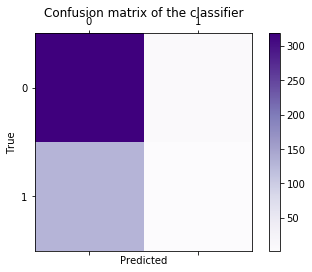

In [40]:
# Evaluate how this saturated model does
X_xtest=add_constant(X_xtest)
y_pred=satmodel.predict(X_xtest)

# Plot how well the model fit
from sklearn.metrics import confusion_matrix
#import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Purples')

y_pred_class=y_pred>0.5
logreg_accuracy=np.sum(y_pred_class==y_xtest)/y_xtest.shape[0]
print('Model accuracy : %.4f' %logreg_accuracy)
cmatrix=confusion_matrix(y_xtest,y_pred_class) #,labels=logitmodel.classes_)
cmatrix
# Show it as a heatmap
#ax=sns.heatmap(cmatrix, vmin=0, vmax=np.max(cmatrix))


# Plot the confusion matrix
#labels = logitmodel.classes_
print(cmatrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cmatrix,cmap=cmap)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ok...saturated model doesn't do that well. So let's be a little more flexible with our pvalue and run the risk of type 2 error.
If we use a p=0.1, we find that the only significant coefficients are grouped_age_60_100, change in medication, discharge to home_NA,  primary_diagnosis_neoplasm, num_lab_procedures (nearing significance, so let's keep it...), number emergencies... so let's create a reduced version of this saturated model with just these predictors

Let's also include predictors that may have been useful that we found in EDA - which were (additionally) admission type ID, # lab procedures, # emergecy, time in hospital

In [13]:
X_trainNew=X_train.loc[:,['grouped_age_[60-100)','change_No',\
                          'primary_diagnosis_neoplasm',\
                          'num_lab_procedures','number_emergency','admission_type_id_Emergency'\
                          ,'admission_type_id_NA','admission_type_id_Urgent','num_procedures',\
                         'time_in_hospital']]

X_trainNew=add_constant(X_trainNew)
logreg=Logit(y_train,X_trainNew)

reducedmodel=logreg.fit(maxiter=100,verbose=True,method='bfgs')
# Check if logitmodel converged, if not start where we left
while reducedmodel.mle_retvals['converged']==False:
    reducedmodel=logreg.fit(maxiter=100,start_params=reducedmodel.params,verbose=True,method='bfgs')
    
# Let's take a look at the model
reducedmodel.summary()





Optimization terminated successfully.
         Current function value: 0.594285
         Iterations: 53
         Function evaluations: 56
         Gradient evaluations: 56


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                 1828
Model:                          Logit   Df Residuals:                     1817
Method:                           MLE   Df Model:                           10
Date:                Wed, 27 Feb 2019   Pseudo R-squ.:                 0.02235
Time:                        03:28:11   Log-Likelihood:                -1086.4
converged:                       True   LL-Null:                       -1111.2
                                        LLR p-value:                 3.079e-07
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.3350      0.188     -7.109      0.000      -1.703      -0.967
grouped_age_[60-100)            0.5052      0.107      4.719      0.000       0.295       0.715
change_No                      -0.2325      0.105     -2.215      0.027      -0.438      -0.027
primary_diagnosis_neoplasm     -0.5513      0.312     -1.770      0.077      -1.162       0.059
num_lab_procedures              0.0070      0.003      2.288      0.022       0.001       0.013
number_emergency                0.4169      0.177      2.352      0.019       0.070       0.764
admission_type_id_Emergency     0.0768      0.150      0.512      0.609      -0.217       0.371
admission_type_id_NA            0.0854      0.183      0.467      0.640      -0.273       0.444
admission_type_id_Urgent       -0.1713      0.173     -0.993      0.321      -0.510       0.167
num_procedures                 -0.0054      0.032     -0.167      0.867      -0.068       0.057
time_in_hospital                0.0067      0.022      0.309      0.757      -0.036       0.049
===============================================================================================
"""

Model accuracy : 0.7090
[[322   3]
 [130   2]]


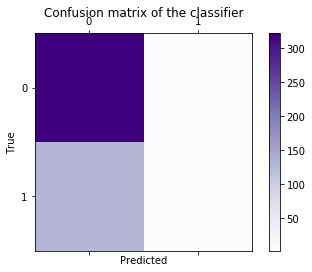

In [18]:
# Evaluate how this reduced model does
X_xtestNew=X_xtest.loc[:,['grouped_age_[60-100)','change_No',\
                          'primary_diagnosis_neoplasm',\
                          'num_lab_procedures','number_emergency','admission_type_id_Emergency'\
                          ,'admission_type_id_NA','admission_type_id_Urgent','num_procedures',\
                         'time_in_hospital']]
X_xtestNew=add_constant(X_xtestNew)
y_predNew=reducedmodel.predict(X_xtestNew)

# Plot how well the model fit
from sklearn.metrics import confusion_matrix
#import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Purples')

y_pred_classNew=y_predNew>0.5
logreg_accuracy=np.sum(y_pred_classNew==y_xtest)/y_xtest.shape[0]
print('Model accuracy : %.4f' %logreg_accuracy)
cmatrix=confusion_matrix(y_xtest,y_pred_classNew) #,labels=logitmodel.classes_)
cmatrix
# Show it as a heatmap
#ax=sns.heatmap(cmatrix, vmin=0, vmax=np.max(cmatrix))


# Plot the confusion matrix
#labels = logitmodel.classes_
print(cmatrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cmatrix,cmap=cmap)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ok, a slight improvement with reduced model, but what we included in the eda didn't really add much predictive power, so let's drop it and include interactions


In [22]:
#from sklearn.preprocessing import PolynomialFeatures

# First define the new data 
X_trainInt=X_train.loc[:,['grouped_age_[60-100)','change_No',\
                          'primary_diagnosis_neoplasm',\
                          'num_lab_procedures','number_emergency']]
X_xtestInt=X_xtest.loc[:,['grouped_age_[60-100)','change_No',\
                          'primary_diagnosis_neoplasm',\
                          'num_lab_procedures','number_emergency']]
# Ok, build the interaction terms... only one quantity, rest are categorical so it's 
# pretty straight-forward

unique_var=X_trainInt.columns

for ii, var in enumerate(unique_var):
    other_terms=unique_var[ii+1:]
    for jj, var2 in enumerate(other_terms):
        int_name=unique_var[ii]+other_terms[jj]
        X_trainInt.loc[:,int_name]=X_trainInt.loc[:,var]*X_trainInt.loc[:,var2]
        X_xtestInt.loc[:,int_name]=X_xtestInt.loc[:,var]*X_xtest.loc[:,var2]


X_trainInt=add_constant(X_trainInt)
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#int_terms=poly.fit_transform(X_trainInt)
#X_trainInt=pd.concat([X_trainInt,int_terms],axis=1)

logreg=Logit(y_train,X_trainInt)

intmodel=logreg.fit(maxiter=100,verbose=True,method='bfgs')
# Check if logitmodel converged, if not start where we left
while intmodel.mle_retvals['converged']==False:
    intmodel=logreg.fit(maxiter=100,start_params=intmodel.params,verbose=True,method='bfgs')
    
# Let's take a look at the model
intmodel.summary()



Optimization terminated successfully.
         Current function value: 0.591454
         Iterations: 93
         Function evaluations: 99
         Gradient evaluations: 99


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                 1828
Model:                          Logit   Df Residuals:                     1812
Method:                           MLE   Df Model:                           15
Date:                Wed, 27 Feb 2019   Pseudo R-squ.:                 0.02700
Time:                        03:31:47   Log-Likelihood:                -1081.2
converged:                       True   LL-Null:                       -1111.2
                                        LLR p-value:                 2.512e-07
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.0110      0.257     -3.926      0.000      -1.516      -0.506
grouped_age_[60-100)                              -0.1043      0.284     -0.367      0.714      -0.661       0.453
change_No                                         -0.4102      0.281     -1.462      0.144      -0.960       0.140
primary_diagnosis_neoplasm                         0.5179      0.777      0.667      0.505      -1.004       2.040
num_lab_procedures                                 0.0034      0.005      0.629      0.529      -0.007       0.014
number_emergency                                  -0.4330      0.497     -0.872      0.383      -1.407       0.541
grouped_age_[60-100)change_No                      0.4381      0.215      2.040      0.041       0.017       0.859
grouped_age_[60-100)primary_diagnosis_neoplasm     0.0901      0.696      0.129      0.897      -1.274       1.454
grouped_age_[60-100)num_lab_procedures             0.0093      0.006      1.636      0.102      -0.002       0.020
grouped_age_[60-100)number_emergency               0.2391      0.419      0.571      0.568      -0.582       1.060
change_Noprimary_diagnosis_neoplasm               -0.4525      0.631     -0.717      0.474      -1.690       0.785
change_Nonum_lab_procedures                       -0.0025      0.006     -0.436      0.663      -0.013       0.009
change_Nonumber_emergency                          0.2450      0.390      0.628      0.530      -0.520       1.010
primary_diagnosis_neoplasmnum_lab_procedures      -0.0281      0.017     -1.655      0.098      -0.061       0.005
primary_diagnosis_neoplasmnumber_emergency        -0.0702      0.775     -0.091      0.928      -1.589       1.449
num_lab_proceduresnumber_emergency                 0.0179      0.011      1.666      0.096      -0.003       0.039
==================================================================================================================
"""

Model accuracy : 0.7112
[[323   2]
 [130   2]]


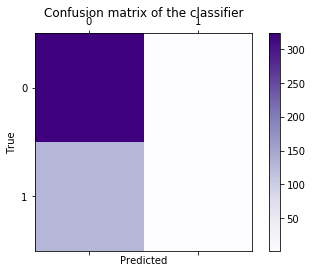

In [23]:
# Ok, evaluate how well this interaction  model works
X_xtestInt=add_constant(X_xtestInt)
y_predInt=intmodel.predict(X_xtestInt)

# Plot how well the model fit
from sklearn.metrics import confusion_matrix
#import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Purples')

y_pred_classInt=y_predInt>0.5
logreg_accuracy=np.sum(y_pred_classInt==y_xtest)/y_xtest.shape[0]
print('Model accuracy : %.4f' %logreg_accuracy)
cmatrix=confusion_matrix(y_xtest,y_pred_classInt) #,labels=logitmodel.classes_)
cmatrix
# Show it as a heatmap
#ax=sns.heatmap(cmatrix, vmin=0, vmax=np.max(cmatrix))


# Plot the confusion matrix
#labels = logitmodel.classes_
print(cmatrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cmatrix,cmap=cmap)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
# Ok, let's just keep the interactions that were significant

# First define the new data 
X_trainInt2=X_trainInt.drop(columns=['const', 'grouped_age_[60-100)', 'change_No',\
       'primary_diagnosis_neoplasm', 'num_lab_procedures', 'number_emergency',\
       'grouped_age_[60-100)change_No',\
       'primary_diagnosis_neoplasmnumber_emergency'])
X_xtestInt2=X_xtestInt.drop(columns=['const', 'grouped_age_[60-100)', 'change_No',\
       'primary_diagnosis_neoplasm', 'num_lab_procedures', 'number_emergency',\
       'grouped_age_[60-100)change_No',\
       'primary_diagnosis_neoplasmnumber_emergency'])

logreg=Logit(y_train,X_trainInt2)

intmodel2=logreg.fit(maxiter=100,verbose=True,method='bfgs')
# Check if logitmodel converged, if not start where we left
while intmodel2.mle_retvals['converged']==False:
    intmodel2=logreg.fit(maxiter=100,start_params=intmodel2.params,verbose=True,method='bfgs')
    
# Let's take a look at the model
intmodel2.summary()

Optimization terminated successfully.
         Current function value: 0.644786
         Iterations: 45
         Function evaluations: 54
         Gradient evaluations: 54


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                 1828
Model:                          Logit   Df Residuals:                     1820
Method:                           MLE   Df Model:                            7
Date:                Wed, 27 Feb 2019   Pseudo R-squ.:                -0.06073
Time:                        03:43:25   Log-Likelihood:                -1178.7
converged:                       True   LL-Null:                       -1111.2
                                        LLR p-value:                     1.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
grouped_age_[60-100)primary_diagnosis_neoplasm    -0.0693      0.542     -0.128      0.898      -1.132       0.994
grouped_age_[60-100)num_lab_procedures            -0.0016      0.002     -0.857      0.392      -0.005       0.002
grouped_age_[60-100)number_emergency               0.0977      0.353      0.277      0.782      -0.594       0.790
change_Noprimary_diagnosis_neoplasm               -0.5132      0.527     -0.973      0.330      -1.547       0.520
change_Nonum_lab_procedures                       -0.0186      0.002     -9.467      0.000      -0.022      -0.015
change_Nonumber_emergency                          0.2466      0.346      0.713      0.476      -0.431       0.925
primary_diagnosis_neoplasmnum_lab_procedures      -0.0204      0.014     -1.455      0.146      -0.048       0.007
num_lab_proceduresnumber_emergency                 0.0027      0.005      0.488      0.626      -0.008       0.013
==================================================================================================================
"""

Model accuracy : 0.7068
[[323   2]
 [130   2]]


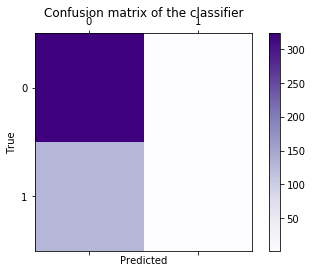

In [32]:
# Ok, evaluate how well this interaction  model works
y_predInt2=intmodel2.predict(X_xtestInt2)
# We already added constant above

# Plot how well the model fit

y_pred_classInt2=y_predInt2>0.5
logreg_accuracy=np.sum(y_pred_classInt2==y_xtest)/y_xtest.shape[0]
print('Model accuracy : %.4f' %logreg_accuracy)
cmatrix=confusion_matrix(y_xtest,y_pred_classInt) #,labels=logitmodel.classes_)
cmatrix
# Show it as a heatmap
#ax=sns.heatmap(cmatrix, vmin=0, vmax=np.max(cmatrix))


# Plot the confusion matrix
#labels = logitmodel.classes_
print(cmatrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cmatrix,cmap=cmap)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Hmmm..ok, so reduced model seems to be the best thing we can do